## SUM149 and SUM159 cell line analysis

**Author:Dr.Xi Li**

**Created: 08/12/20**

**Language: Python**

This document serves to provide analysis to SUM149 data it takes as input is a loom file extracted from velocyto and provides H5ad for storage, as well as several figures and tables as output.


NOTE: cyto trace file must be present in the directory that this script is located in

In [1]:
from matplotlib import rcParams
import matplotlib.pyplot as plt
import scvelo as scv
import loompy
import pandas as pd
import numpy as np
import os
import scanpy as sc
import scipy.stats as stats
from io import StringIO
from sklearn import linear_model
import seaborn as sns
import scanpy.external as sce
 
%matplotlib inline

In [2]:
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.settings.set_figure_params('scvelo')
# for beautified visualization

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.serif'] = ['Arial']

In [3]:
np.set_printoptions(threshold=np.inf)

## input sample path

First lets find the directory that we are working in

**Note:  SigsDir must be changed depending on the user to allow for proper use of this script**

In [4]:
os.getcwd()

'/mnt/c9b6130c-37e5-4f62-becc-dd4240b42021/TNBC_JQ1'

In [5]:
#set directory to where signature gene lists locates
SigsDir="/mnt/533ee9c3-18c0-4c72-a09e-d9ce5a10ef9e/sig"

In [45]:
#set the project_ID and directory for outputs

project_ID="SUM149"
scv.settings.figdir=f'{project_ID}_figures'

In [59]:
#set the project_ID and directory for outputs

adata =scv.read("combine_t.loom")
adata.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [72]:
#load the data file 

adata_ = sc.read(f'{project_ID}_figures/{project_ID}_dy.h5ad')

In [13]:
#we need to make a directory to store the files in
try:
    directoryName=project_ID+"_figures"
    os.mkdir(directoryName)
except:
    pass

#we need to make a directory to store the files in
try:
    directoryName=project_ID+"_DEG"
    os.mkdir(directoryName)
except:
    pass


In [ ]:
Sample_idx=pd.Series("Unknown", index=adata.obs_names)
m=0
for i in np.unique(adata.obs.Sample_Cluster):   
    Sample_idx[adata.obs.Sample_Cluster==i]=m
    m=m+1
adata.obs["Sample_idx"]=Sample_idx.values
adata.obs["Sample_idx"]=adata.obs["Sample_idx"].astype(float)

## Preprocess the Data

now we will take the files from the previous section where we determined spliced/unspliced RNA counts and use them to create RNA velocity trajectory as well as investigate biological alternation in each cell

In [60]:
#Note if you have loaded the processed file then dont run this line, this line should only br run if you read in the alternative raw_count file 
adata.var['mt'] = adata.var_names.str.startswith('MT-')
adata.var['rp'] = adata.var_names.str.startswith('RP')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(adata, qc_vars=['rp'], percent_top=None, log1p=False, inplace=True)
#sc.pl.violin(adata, ['n_vars'], groupby='Sample_ID', stripplot=False) 

... storing 'Sample_Cluster' as categorical
... storing 'Chromosome' as categorical
... storing 'Strand' as categorical


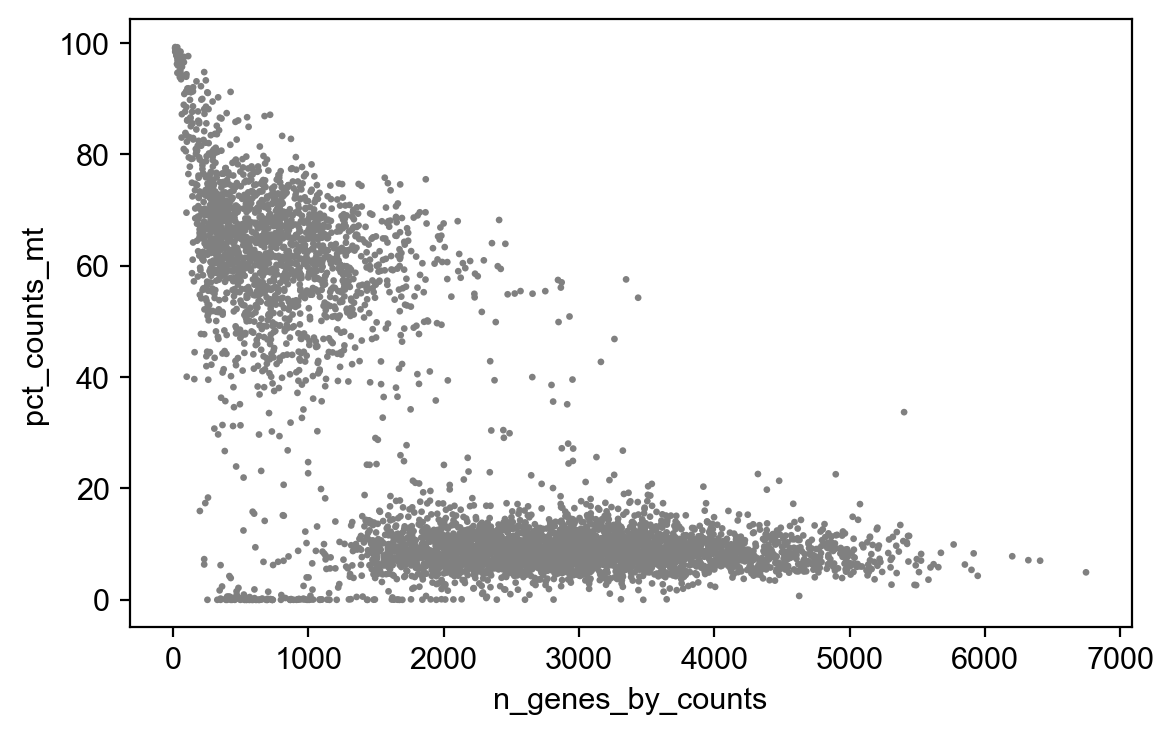

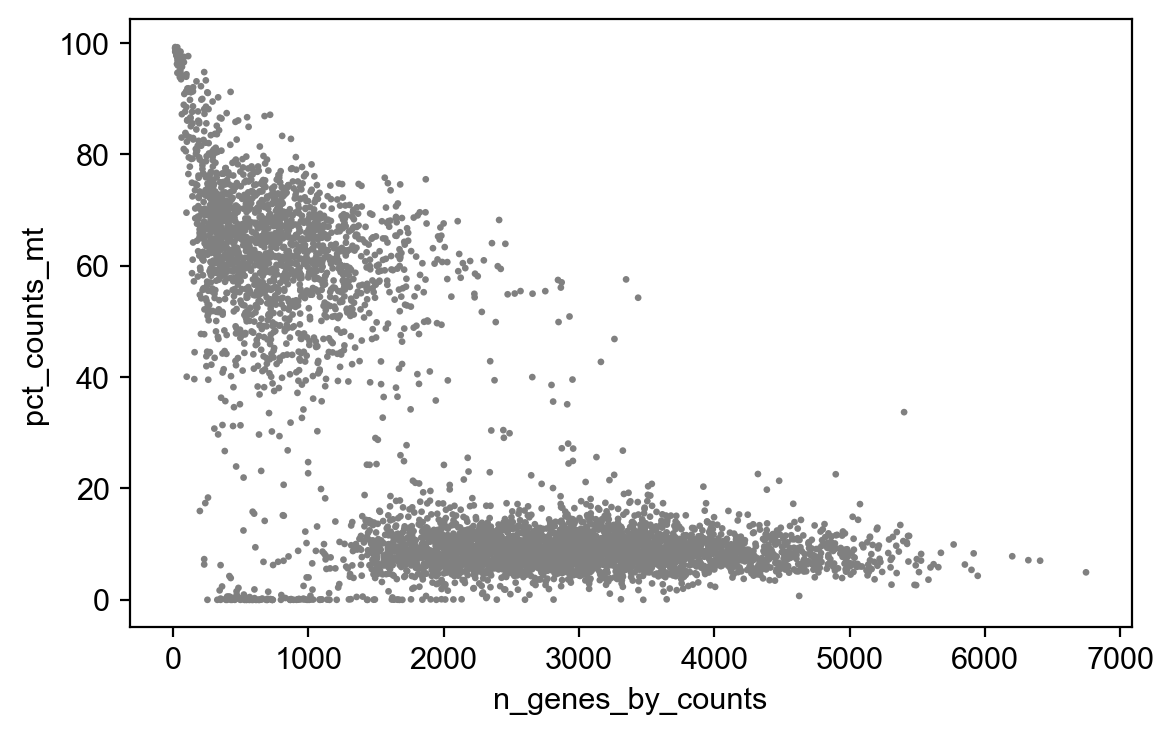

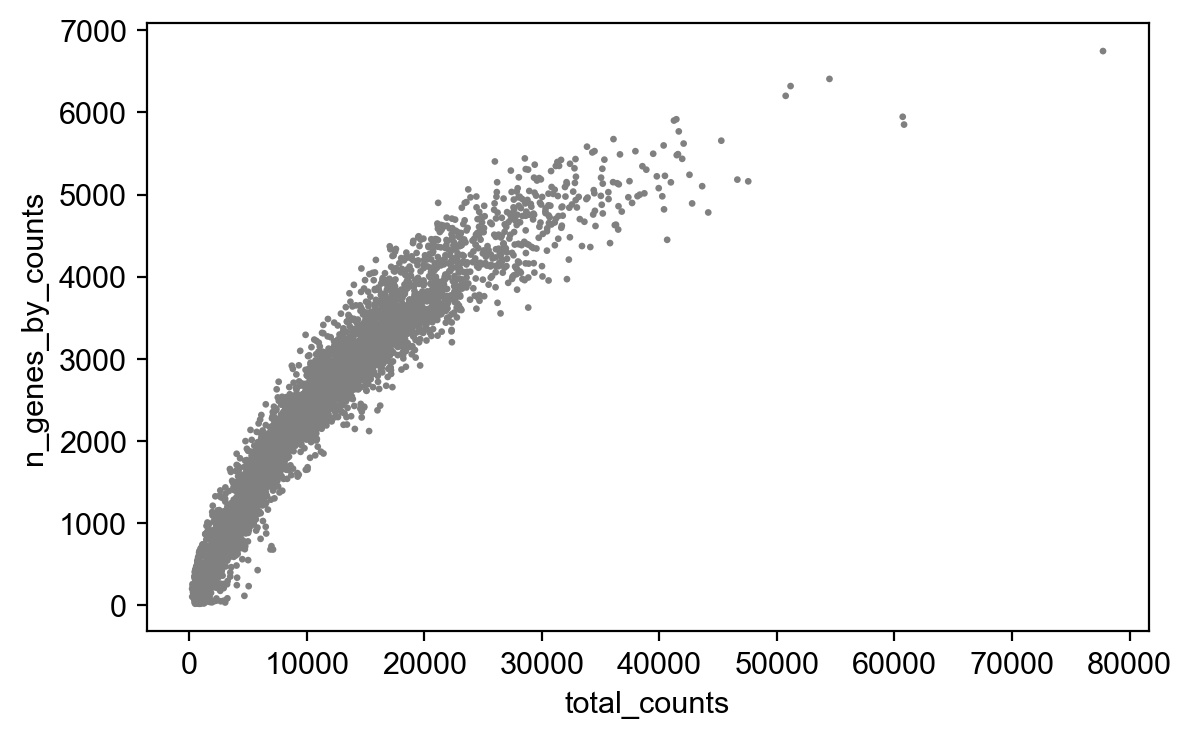

In [61]:
#Note if you have loaded the processed file then dont run this line, this line should only br run if you read in the alternative raw_count file 
sc.pl.scatter(adata, x='n_genes_by_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='n_genes_by_counts', y='pct_counts_mt', )#color="clusters",)
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts',)#color="clusters")


In [62]:
#Note if you have loaded the processed file then dont run this line, this line should only br run if you read in the alternative raw_count file
adata = adata[adata.obs.n_genes_by_counts < 5000, :] #we want the cell to contain less than 5000 total gene detected in order to avoid doublets
adata = adata[adata.obs.total_counts < 45000, :]
adata = adata[adata.obs.n_genes_by_counts > 200, :] #we want the cell to contain more than 200 total gene detected in order to avoid bad cells
adata = adata[adata.obs.total_counts > 400, :]# we want the cell to contain more than 400 (200*2) total counts (UMI) detected in order to avoid bad cells
adata = adata[adata.obs.pct_counts_mt < 55, :]# we want the cell to contain less than 55 percent mitochondrial genes in order to avoid bad cells

adata

View of AnnData object with n_obs × n_vars = 3586 × 33538
    obs: 'Clusters', 'Sample_Cluster', '_X', '_Y', 'num', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rp', 'pct_counts_rp'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'mt', 'rp', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

when cell membrane is broken, cytoplasmic RNA will be easy to leek out, but mitochondia are still too big to pass the broken membrane, so that high percentage usually suggestes bad cells. But on the contrary, there is paper saying stemness like cell containing high percentage mitochondrial genes to survie stress, so we have to go back to this parameters according to what we will have found later.

***

**Continued data processing**

In [63]:
scv.pp.filter_and_normalize(adata, flavor="cell_ranger", min_counts=2,n_top_genes=4000, )

Trying to set attribute `.obs` of view, copying.


Filtered out 16462 genes that are detected 2 counts (spliced).
Normalized count data: X, spliced, unspliced.
Extracted 4000 highly variable genes.
Logarithmized X.


In [66]:
scv.tl.score_genes_cell_cycle(adata) # calculate cell cycle score with scv internal function and its gene list of s phase and g2m phase, then we will have two observations---"S_score" and "G2M_score" added in adata 
sc.pp.regress_out(adata, keys=["G2M_score","S_score","total_counts", "n_genes_by_counts"] , n_jobs=None, copy=False) # we remove cell cycle effects
scv.pp.moments(adata,n_pcs=10, n_neighbors=150, mode="distances") # we calculate a moment matrix for further RNA velocity analysis

... storing 'phase' as categorical


calculating cell cycle phase
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on distances
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [67]:
#calculate umap
scv.tl.umap(adata, n_components=2, min_dist=0.3, spread=1, maxiter=None, alpha=1.0,
            gamma=1, negative_sample_rate=5, init_pos="spectral", random_state=0, a=None,
            b=None, copy=False, method="umap", neighbors_key=None)

In [68]:
#calculate louvain clusters based on the umap we generated previously
sc.tl.louvain(adata, resolution=0.7)
adata.obs["clusters"]=adata.obs["louvain"]

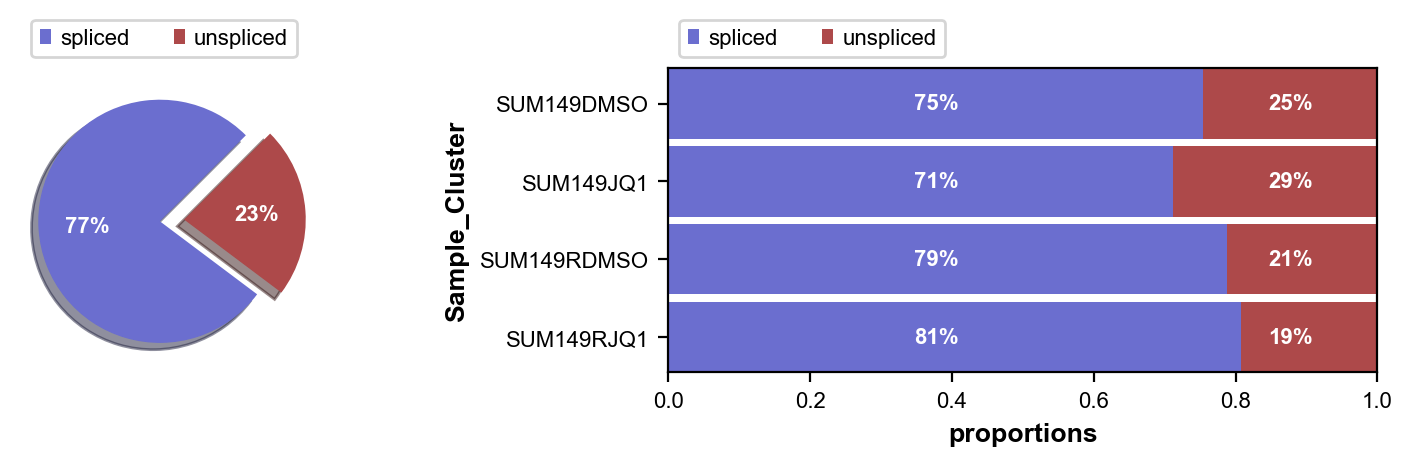

In [69]:
#check proportions of spliced and unspliced RNA in each cluster
scv.pl.proportions(adata, groupby="Sample_Cluster")

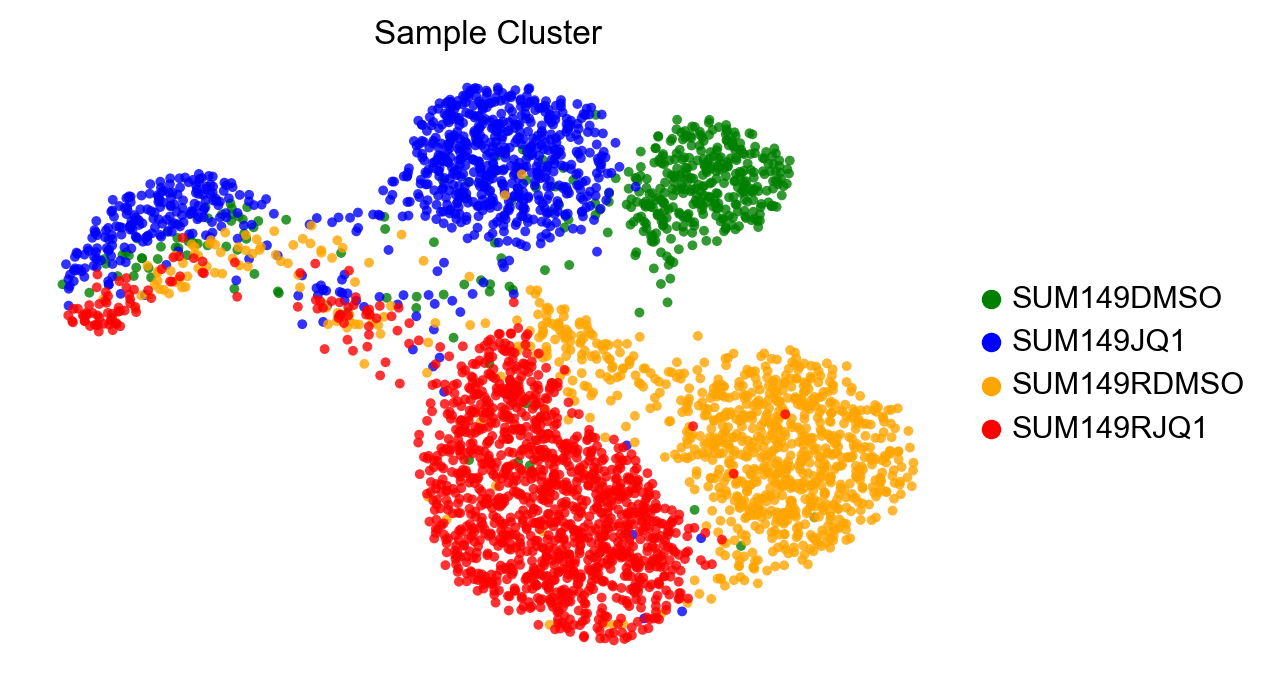

In [73]:
#plot umap grouped by treatment
scv.pl.scatter(adata, #save="SUM159_densmap.pdf",
               basis="umap",
           color="Sample_Cluster",legend_loc="right",
        #  palette=["darkseagreen","lightblue","lightsalmon","orchid"],
            size=50, alpha=0.8,
            )

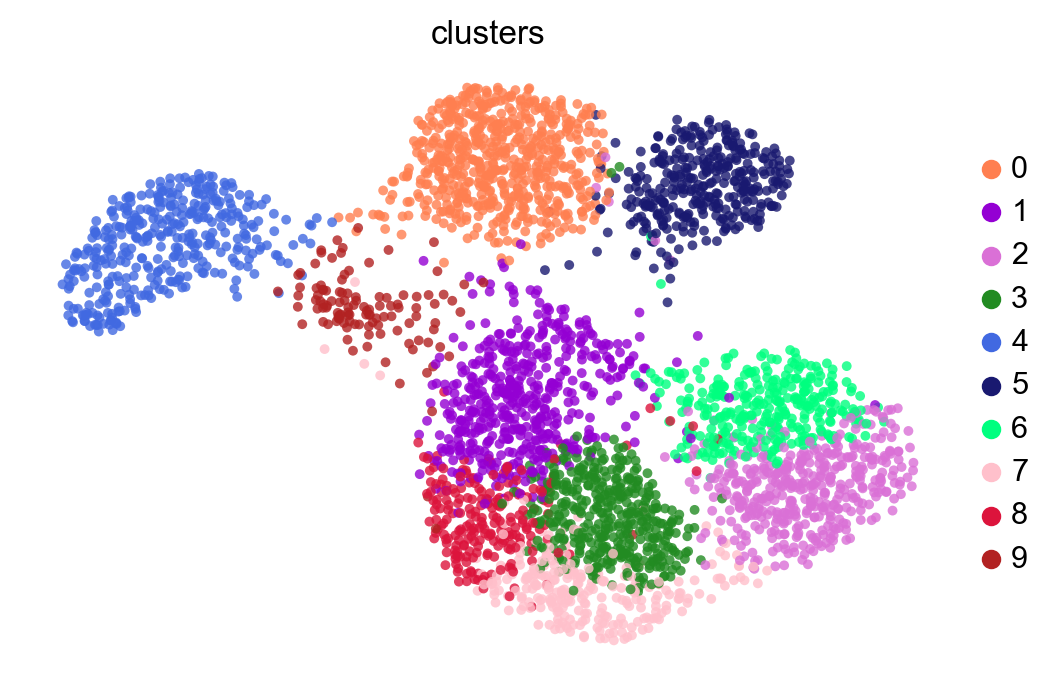

In [74]:
#plot umap grouped by treatment
scv.pl.scatter(adata, #save="v_clusters_densmap.pdf",
               basis="umap",
           color="clusters",legend_loc="right",
          palette=["coral","darkviolet","orchid", "forestgreen","royalblue","MidnightBlue","SpringGreen","Pink","crimson",
            "firebrick",  "gold", "olivedrab","lightcoral","greenyellow",
            "tan","slategrey","lightseagreen",
            "maroon","lightsteelblue","lightskyblue","dimgrey",
            "indigo","darkturquoise"],
            size=50, alpha=0.8,
            )

# TRAJECTORY

read previous h5d file 

In [ ]:
#calculate velocity with stochastic mode first
scv.tl.velocity(adata,  mode='stochastic',use_latent_time=None)
scv.tl.velocity_graph(adata_)

In [ ]:
#calculate and plot out pseudotime
scv.tl.terminal_states(adata, self_transitions=False)
scv.tl.velocity_pseudotime(adata)
scv.pl.scatter(adata, color='velocity_pseudotime', cmap='gnuplot', perc=(2,98), save="pseudotime.pdf")

In [ ]:
#we have to calculate velocity first before we recover dynamics 
scv.tl.recover_dynamics(adata, var_names="velocity_genes" ,plot_results=False, 
                        fit_connected_states=True, use_raw=False, 
                        fit_scaling=True)


In [ ]:
#calculate velocity one more time with dynamical mode
#scv.tl.velocity(adata,  mode='dynamical',use_latent_time=None)
scv.tl.velocity_graph(adata)

In [ ]:
#calculate and plot out dynamical pseudotime
scv.tl.terminal_states(adata, self_transitions=False)
scv.tl.velocity_pseudotime(adata)
scv.pl.scatter(adata, color='velocity_pseudotime', cmap='gnuplot', perc=(2,98), alpha=1,size=50,save="pseudotime.pdf")

In [ ]:
#calculate subclusters according to their velocity profiles
scv.tl.velocity_clusters(adata, vkey="velocity", match_with="clusters", sort_by="velocity_pseudotime", resolution=2.5, min_likelihood=0.42, copy=False)
# plot velocity sub-clustters
scv.pl.scatter(adata, color='velocity_clusters', legend_fontsize=8, legend_fontweight="normal",size=40,
               #save="velocity_cluster.pdf",
               basis="umap",palette=[ "Pink","hotpink","darkviolet","DeepSkyBlue","royalblue"
            ,"MidnightBlue", "SpringGreen","forestgreen"
            ,"gold","orchid","crimson"
            ,"firebrick","olivedrab","lightcoral","greenyellow"
            ,"tan","slategrey","coral","lightseagreen"
            ,"maroon","lightsteelblue","lightskyblue","dimgrey",
            "indigo","darkturquoise"],
              )

computing latent time using root_cells, end_points as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


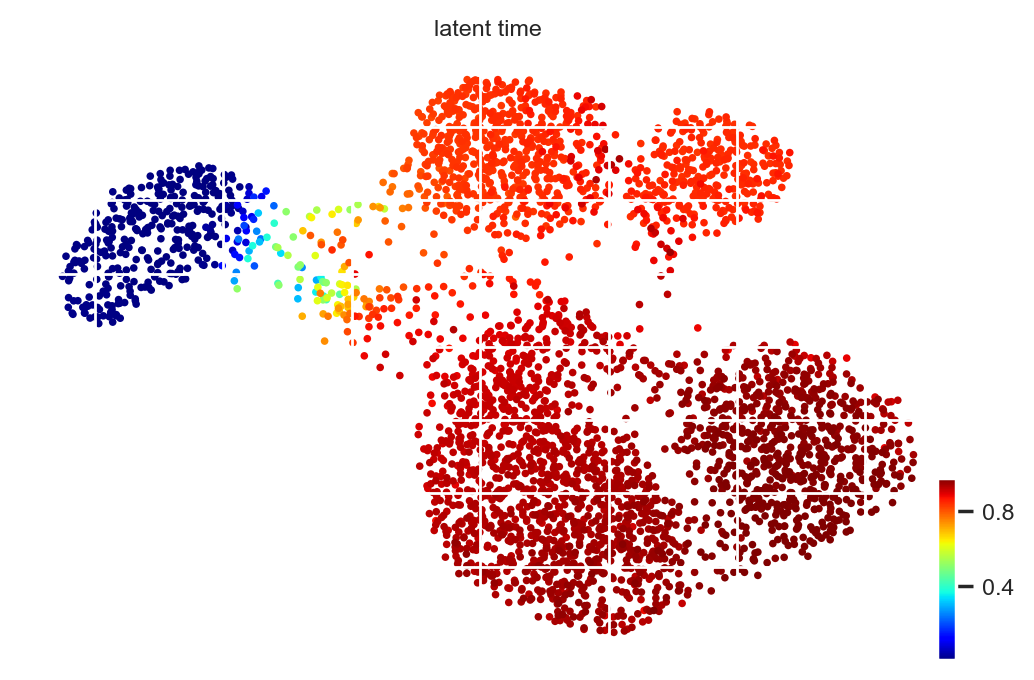

In [317]:
#sometimes we have to do latent-time if the inter population transition is not remarkable, you can refer to their oringinal paper for better understanging of the differences between pseudotime and latent-time
scv.tl.latent_time(adata, vkey='velocity', min_likelihood=0.86, min_confidence=0.98,
                   min_corr_diffusion=0.2, weight_diffusion=True, root_key="root_cells",
                  end_key="end_points", t_max=None, copy=False)
scv.pl.scatter(adata, color='latent_time', cmap='jet', perc=(2,98), size=30)#, save="latent_time.pdf", size=50, smooth=20)#,basis="tsne"

In [318]:
#summarize the arrows of each cluster into 1 single big arrow
adata.uns['neighbors']['distances'] = adata.obsp['distances']
adata.uns['neighbors']['connectivities'] = adata.obsp['connectivities']

scv.tl.paga(adata,use_time_prior="latent_time", root_key="root_cells", end_key="end_points" #when we only do velocity pseudotime trajectory we set the use_time_prior="velociyt_pseudotime", when we do latent time trajectory we have to chage the prior time into latent time
           ,#groups="clusters",
            threshold_root_end_prior=0.6
           ,groups='v_clusters'
           )
df = scv.get_df(adata, 'paga/transitions_confidence', precision=2).T
df.style.background_gradient(cmap='Blues').format('{:.2g}')

running PAGA using priors: ['latent_time', 'root_cells', 'end_points']
    finished (0:00:01) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


saving figure to file SUM149_repro_figures/scvelo_transition.svg


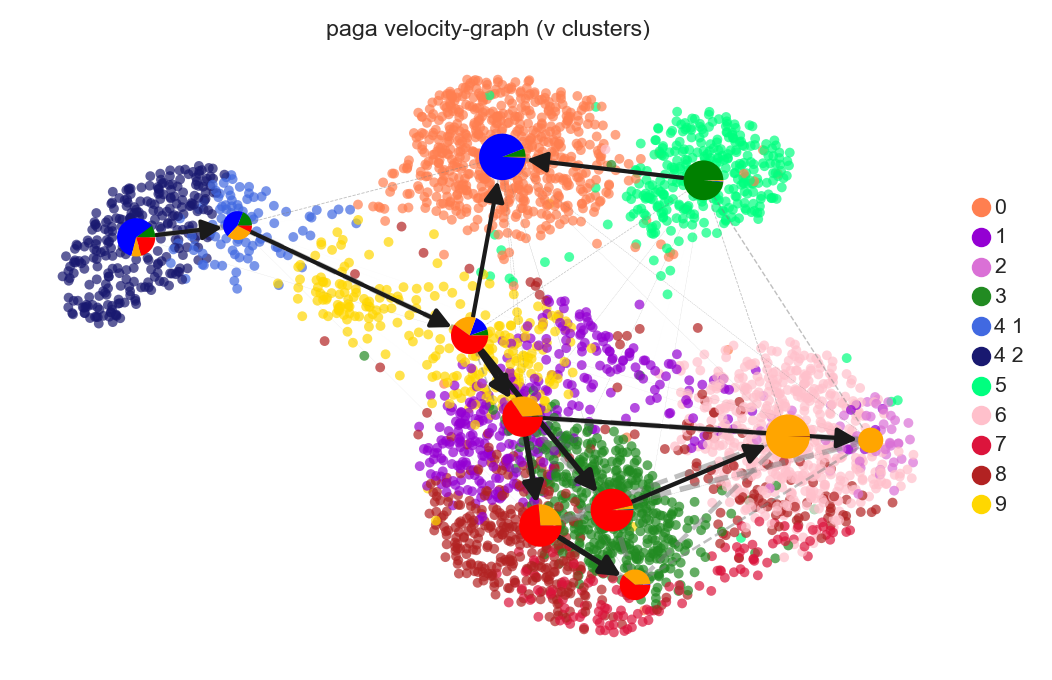

In [319]:
#we can set the color of the big dot into Sample_Cluster so that we will get a pie chart of the percentage of each treatment inside 1 cluster
scv.pl.paga(adata, basis='umap', size=50, alpha=0.7,
            min_edge_width=1.5, node_size_scale=1.5
            ,save="transition.svg"
            #,color="velocity_clusters"
            ,color="Sample_Cluster"
            ,threshold=0., minimum_spanning_tree=False,
           )

saving figure to file SUM149_repro_figures/scvelo_heatmap_heatmap_stem.pdf


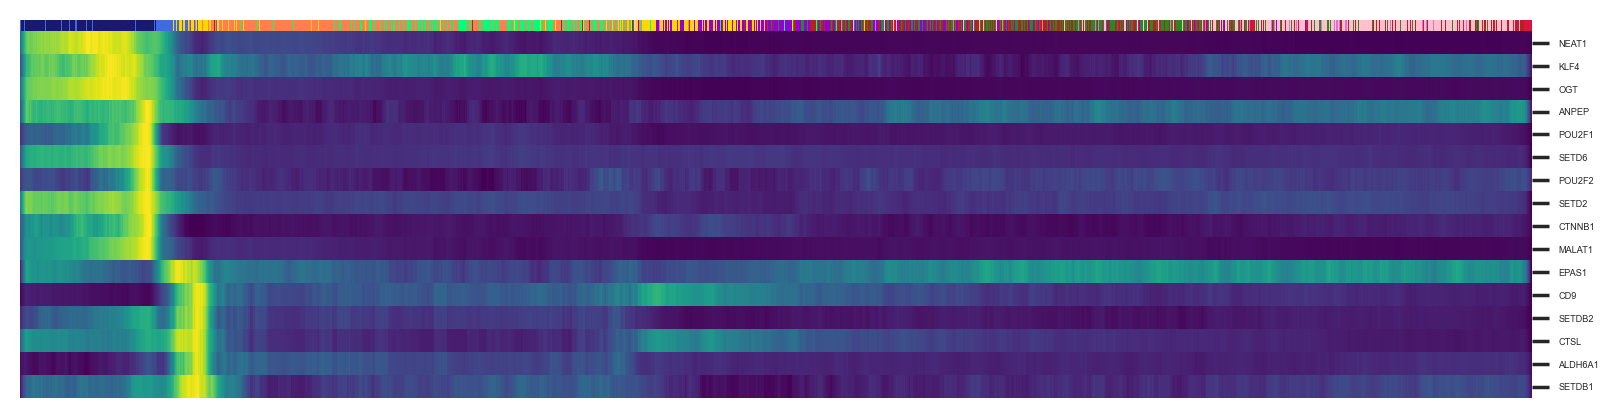

In [314]:
scv.pl.heatmap(adata,sortby="velocity_pseudotime",
               var_names=["ANPEP", "EPAS1","KLF4","CD9","SETDB1","SETDB2","POU2F2","POU2F1",
                          "SETD2","SETD6","OGT","CTNNB1","MALAT1","NEAT1",
                         "PDCD4","ACSS1","HEXB","CTSL","RENBP","DPP7","LY6G6E",
                          "AUH","HEXA","CCNG2","YPEL2","SPRY1","APOE","ALDH6A1"],
               col_color="v_clusters",
               font_scale=0.3,
               figsize=(8,2),
               col_cluster=False,
               colorbar=True,#layer="spliced",
              save="heatmap_stem.pdf")

saving figure to file SUM149_repro_figures/scvelo_heatmap_heatmap_synergistics.pdf


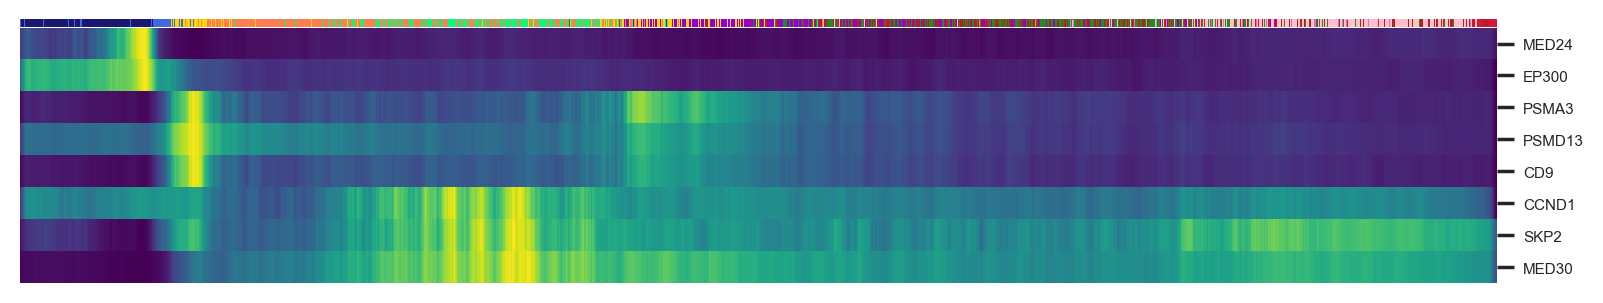

In [315]:
scv.pl.heatmap(adata,sortby="velocity_pseudotime",
               var_names=["MYC","CCND1","MED23","MED24","MED30",
                         "PSMA3","PSMA5","PSMD13",
                          "CDK4","SKP2","BRD2","EP300","CD9"],
               col_color="v_clusters",
               font_scale=0.5,
               figsize=(8,1.5),
               col_cluster=False,
               colorbar=True,
              save="heatmap_synergistics.pdf")

saving figure to file SUM149_repro_figures/scvelo_heatmap_heatmap_resistance.pdf


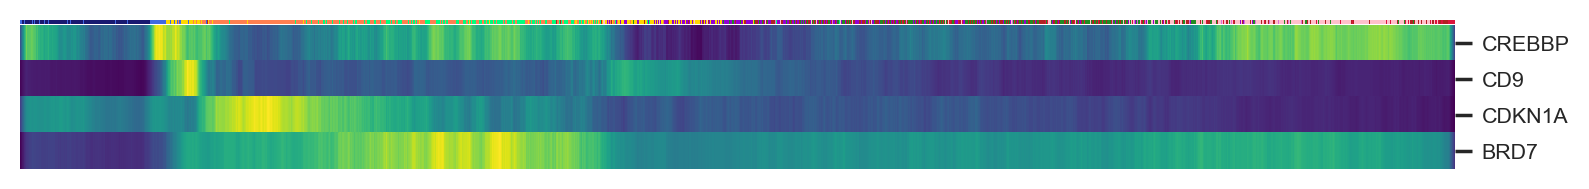

In [316]:
scv.pl.heatmap(adata,sortby="velocity_pseudotime",
               var_names=["BRD4","BRD7","SPOP","CUL3",
                         "CREBBP","NELFB","PRKDC","CDKN1A","ARID1A","TCEB3",
                         "RB1","CD9"],
               col_color="v_clusters",
               font_scale=0.7,
               figsize=(8,1),
               col_cluster=False,
               colorbar=True,
              save="heatmap_resistance.pdf")

In [148]:
# we can save the h5 file with the trajectory results now
adata.write(f'{project_ID}_figures/{project_ID}_dy.h5ad')

# calculate signature scores

In [184]:
# read in an example gene list
gene_list_name="Hallmark_MYC_targets_V1"# put the gene list file name here, the gene list file should be a csv file
gene_list = pd.read_csv(f"{SigsDir}/{gene_list_name}.csv",header=None, sep=",", usecols=[0],)
# convert dataframe or series to list
gene_list_ = gene_list.squeeze().str.strip().tolist()
#glist=np.append(glist,"CD44") # add some specific gene if you want
#glist=np.append(glist,"SETD2")

#calculate a signature expression score by sc internal function. scv cannot calculate a gene list with coefficient
sc.tl.score_genes(adata, score_name=f"{gene_list_name}_score", gene_list=gene_list_, ctrl_size=50, use_raw=False)

In [149]:
# read in an example gene list
gene_list_random="random_1000_human"# put the gene list file name here, the gene list file should be a csv file
random_list = pd.read_csv(f"{SigsDir}/{gene_list_random}.csv",header=None, sep=",", usecols=[0],)
# convert dataframe or series to list
random_list_ = random_list.squeeze().str.strip().tolist()
random_list_=[genes for genes in random_list_ if genes in adata.raw.var_names]

In [150]:
gene_list_name="Embryonic_diapause"
gene_list_coe_=pd.read_csv(f"{SigsDir}/{gene_list_name}.csv",header=0, sep=",",usecols=[0,1],index_col=0)
gene_list_coe_=gene_list_coe_.loc[[genes for genes in gene_list_coe_.index if genes in adata.raw.var_names]]

In [152]:
X_score=0
for genes in gene_list_coe_.index:
    X_score=X_score+gene_list_coe_.loc[genes].values[0]*adata.to_df().loc[:,genes]/len(gene_list_coe_)
for genes in random_list_:
    X_score=X_score-adata.to_df().loc[:,genes]/len(random_list_)
adata.obs["Embryonic_diapause_score"]=X_score

In [ ]:
# we can also make a gene list here manuallly and then calculate a signature s
asymm=["ACTR3","ACTR2","RGS14","RAB10","ETV5","FGF13","ASPM","GOLGA2","STRA8","ING2","INSC","PAX6","POU5F1",
       "PARD3","SOX5","TEAD3","WNT9B","ZBTB16","DOCK7","ARHGEF2",]
sc.tl.score_genes(adata, score_name="asymmetric_division score", gene_list=asymm, ctrl_size=100)

In [82]:
# we can also make a gene list here manuallly and then calculate a signature s
hybrid=["NOTCH1","TGFB1","HGF","NFKB1","WNT","HIF1A","TP53","EPCAM","KRT8","KRT18","KRT19","VIM"]
sc.tl.score_genes(adata, score_name="hybrid EMT/MET score", gene_list=hybrid, ctrl_size=100)

In [ ]:
# we can also make a gene list here manuallly and then calculate a signature s
ABC=[genes for genes in adata.var_names if genes.startswith("ABC")]
sc.tl.score_genes(adata, score_name="ABC score", gene_list=ABC, ctrl_size=10)

In [ ]:
# we can also make a gene list here manuallly and then calculate a signature s
ALDH=[genes for genes in adata.var_names if genes.startswith("ALDH")]
sc.tl.score_genes(adata, score_name="ALDH score", gene_list=ALDH, ctrl_size=10)

In [ ]:
# we can also make a gene list here manuallly and then calculate a signature s
poor_outcome=["CMPK1","AIFM1","FTH1","MTHFD1","EML4","GANAB","CTNNA1","AP1G1","STX12","AP1M1","CAPZB"]
sc.tl.score_genes(adata, score_name="poor_outcome_sig1", gene_list=poor_outcome, ctrl_size=5)

In [ ]:
scv.tl.velocity_confidence(adata)

saving figure to file SUM149_repro_figures/scvelo_Embryonic_diapause_score_98_2.pdf


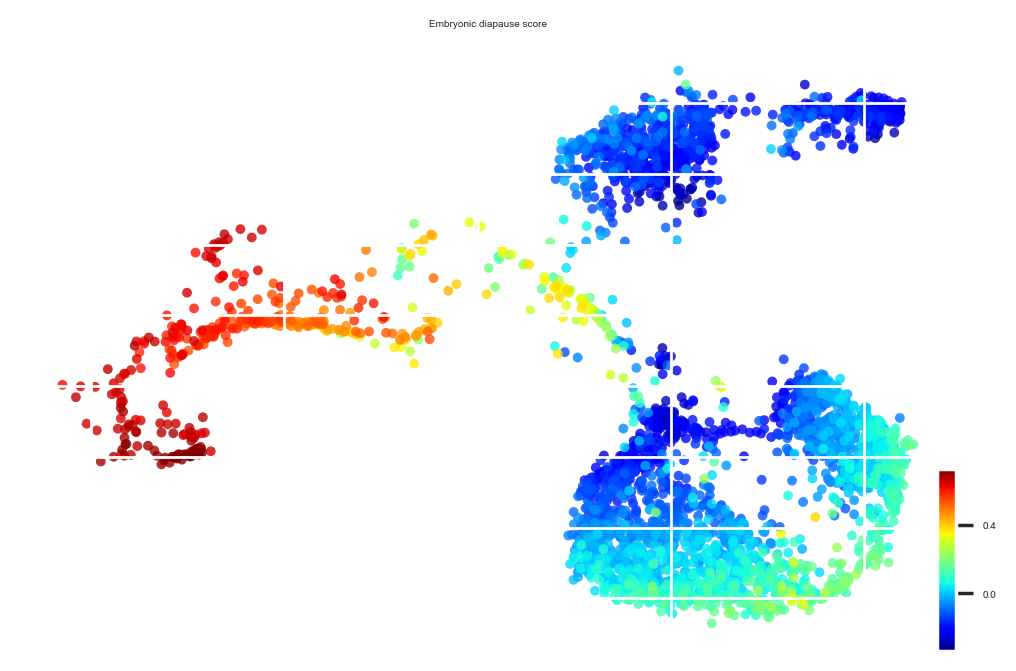

In [157]:
#overlap signature or gene expression in umap
color_name="Embryonic_diapause_score"
scv.pl.scatter(adata,basis="densmap",
               color=color_name, 
               alpha=0.8,size=50, color_map="jet",
               smooth=20, perc=[2, 98],ncols=4,
              save=f"{color_name}_98_2.pdf")

In [ ]:
#overlap signature or gene expression in umap
color_name="S_score"
scv.pl.scatter(adata,basis="densmap",
               color=color_name, 
               alpha=0.8,size=50, color_map="jet",
               smooth=20, perc=[2, 98],ncols=4,
              save=f"{color_name}_98_2_jet_c49.pdf")

In [ ]:
#overlap signature or gene expression in umap
color_name="micrometa_ncb_list_score"
scv.pl.scatter(adata,basis="densmap",
               color=color_name,
               alpha=1,size=80, color_map="jet",
               smooth=20, perc=[2, 98],ncols=4,
              save=f"{color_name}_98_2_jet.pdf")

In [ ]:
#overlap signature or gene expression in umap
color_name="latent_time"
scv.pl.scatter(adata,basis="densmap",
               color=color_name,
               alpha=1,size=80, color_map="jet",
               smooth=20, perc=[2, 98],ncols=4,
              save=f"{color_name}_98_2_jet.pdf")

In [ ]:
adata.obs["CD9_magic"]=adata_magic.to_df()["CD9"]

saving figure to file SUM149_figures/scvelo_CDK6_98_2_jet.pdf


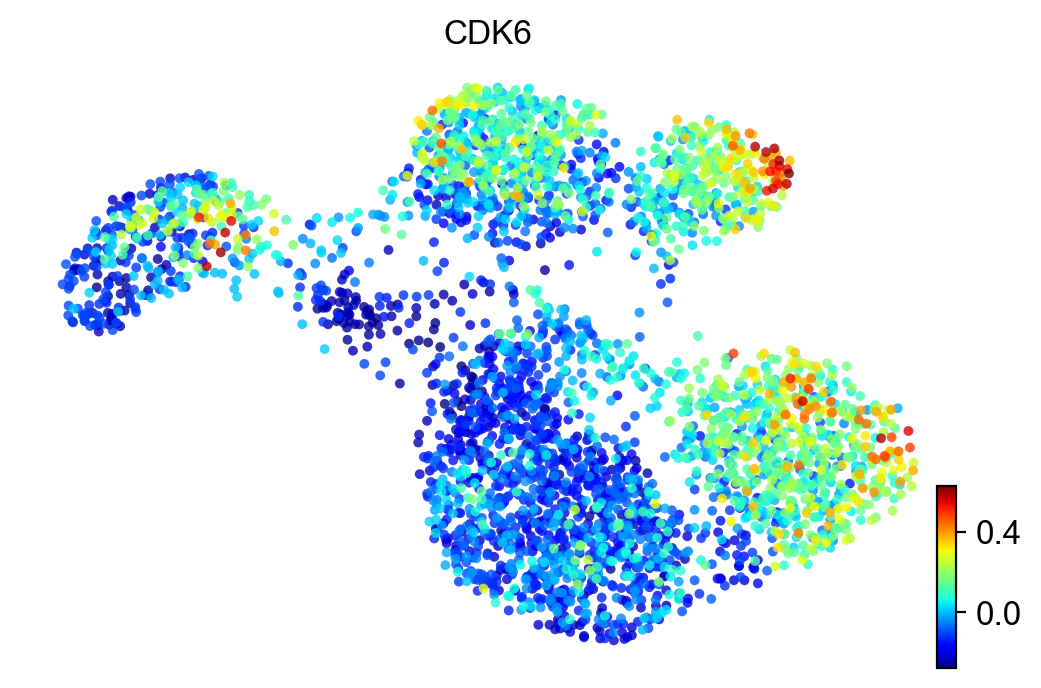

In [34]:
#overlap signature or gene expression in umap
color_name="CDK6"
scv.pl.scatter(adata,
               color=color_name, use_raw=False,
               alpha=0.8,size=50, color_map="jet",
               smooth=10,perc=[2, 98],ncols=4,
              save=f"{color_name}_98_2_jet.pdf")

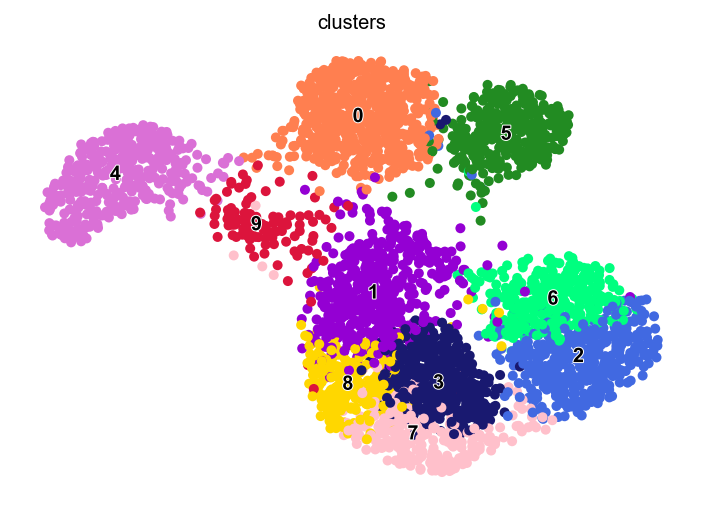

In [174]:
#overlap signature or gene expression in umap
color_name="clusters"
scv.pl.scatter(adata_,
               color=color_name, 
               alpha=1,size=100, 
               smooth=20, perc=[2, 98],ncols=4,
              )#save=f"{color_name}_98_2_jet.pdf")

## Correlations

In [ ]:
# we can build a correlation between two features with a resolution of single cell
x_label="trajectory_wishbone"
y_label="latent_time"
x=adata.obs[f"{x_label}"].values
y=adata.obs[f"{y_label}"].values
z=f"{x_label}_{y_label}"

In [708]:
#call color information of each cell
color=scv.utils.interpret_colorkey(adata,c="v_clusters")

<Figure size 600x600 with 0 Axes>

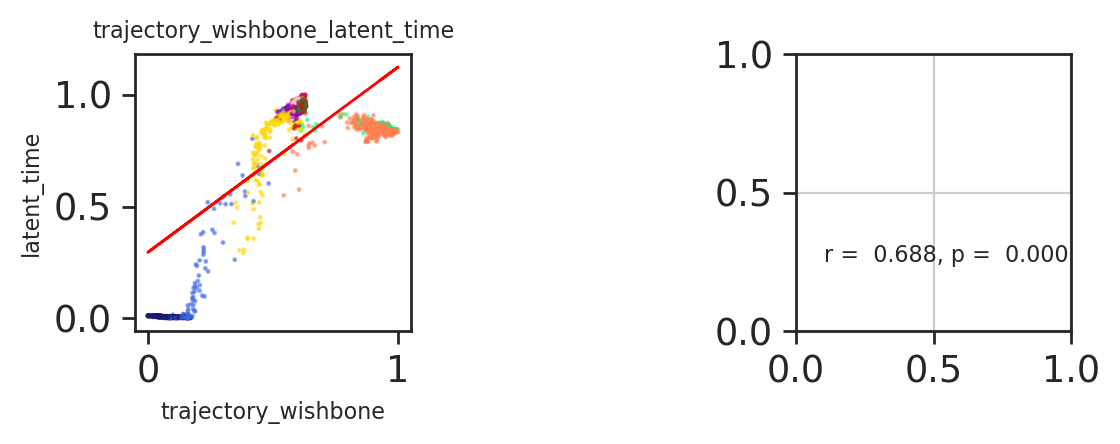

In [709]:
plt.figure(figsize = (6,6))  #set figure size
fig = plt.figure() 
ax1 = fig.add_subplot(231) 
ax1.set_title(z, fontdict={"size":8} ) 
 
r,p = stats.pearsonr(x, y) 

ax1.scatter(x, y,c=color,s=1,alpha=0.5) # plot scatters

regr = linear_model.LinearRegression()
regr.fit(x.reshape(-1,1),y) 
a, b = regr.coef_, regr.intercept_
ax1.plot(x,  regr.predict(x.reshape(-1,1)), color='red', linewidth=1)


plt.xlabel(x_label, fontdict={"size":8})
plt.ylabel(y_label, fontdict={"size":8}) 

ax2 = fig.add_subplot(233)
ax2.text(0.1, 0.25, r'r = %6.3f, p = %6.3f'%(r,p), fontdict={"size":8})
#ax2.text(0.1, 0.5,r'a = %6.3f, b = %6.3f'%(a,b), fontdict={"size":8})
plt.grid()  # show grids


#make the file that we will store these plots in 
try:
    directoryName=project_ID+"_DEG"
    os.mkdir(directoryName)
except:
    pass

plt.savefig(f"{project_ID}_DEG/pearson_{z}.pdf",dpi=300)
plt.show()  # show plots

In [ ]:
# or we can build a correlation between two clusters after grouping the feature level by clusters
pseudo = pd.DataFrame(adata.obs["latent_time"].values,columns=["latent_time"],index=adata.obs['v_clusters'])
pseudotime = pseudo.groupby(level=0).mean()

In [ ]:
# or we can build a correlation between two clusters after grouping the feature level by clusters
asymm= pd.DataFrame(adata.obs["asymmetric_division score"].values,columns=["asymmetric_division score"],index=adata.obs['v_clusters'])
asymm = asymm.groupby(level=0).mean()

In [ ]:
# or we can build a correlation between two clusters after grouping the feature level by clusters
MSI = pd.DataFrame(adata.obs["Da_MSI_score"].values,columns=["Da_MSI_score"],index=adata.obs['clusters'])
MSI = MSI.groupby(level=0).mean()

In [ ]:
# or we can build a correlation between two clusters after grouping the feature level by clusters
MSI2 = pd.DataFrame(adata.obs["MSI_score"].values,columns=["MSI_score"],index=adata.obs['clusters'])
MSI2 = MSI2.groupby(level=0).mean()

In [ ]:
# or we can build a correlation between two clusters after grouping the feature level by clusters
stem_diff = pd.DataFrame(adata_.obs["stem_diff_score"].values,columns=["stemness"],index=adata_.obs['Sample'])
stem_diff = stem_diff.groupby(level=0).mean()

In [ ]:
# or we can build a correlation between two clusters after grouping the feature level by clusters
Embry_diap = pd.DataFrame(adata.obs["micrometa_ncb_list_score"].values,columns=["micrometa_ncb_list_score"],index=adata.obs['lineage'])
Embry_diap = Embry_diap.groupby(level=0)
Embry_diap

In [ ]:
# or we can build a correlation between two clusters after grouping the feature level by clusters
poor_outcome = pd.DataFrame(adata.obs["poor_outcome_signature2_score"].values,columns=["poor_outcome_signature2_score"],index=adata.obs['clusters'])
poor_outcome = poor_outcome.groupby(level=0).mean()

In [ ]:
# or we can build a correlation between two clusters after grouping the feature level by clusters
cluster9 = pd.DataFrame(adata.obs["v_clusters"].values.astype(int),columns=["v_clusters"],index=adata.obs['v_clusters'])
cluster9 = cluster9.groupby(level=0).mean()

In [ ]:
# or we can build a correlation between two clusters after grouping the feature level by clusters
CD9 = pd.DataFrame(adata.to_df(layer="spliced").loc[:,"CD9"].values,columns=["CD9"],index=adata.obs['v_clusters'])
CD9 = CD9.groupby(level=0).mean()

In [ ]:
# or we can build a correlation between two clusters after grouping the feature level by clusters
Cytotrace = pd.DataFrame(adata.obs["cytoTRACE"].values,columns=["cytoTRACE"],index=adata.obs['v_clusters'])
Cytotrace = Cytotrace.groupby(level=0).mean()

In [ ]:
x=pseudotime
y=cluster9
z="pseudo_cluster"

In [ ]:
plt.figure(figsize = (6,6))
fig = plt.figure() 
ax1 = fig.add_subplot(231) 
ax1.set_title(f"Pearson correlation stem_diff_{z}", fontdict={"size":8})  
 
r,p = stats.pearsonr(x.values[:,0], y.values[:,0]) 

ax1.scatter(x.values.T, y.values.T,color=adata.uns["v_clusters_colors"]) 

regr = linear_model.LinearRegression()
regr.fit(x.values[:,0].reshape(-1,1),y.values[:,0]) 
a, b = regr.coef_, regr.intercept_
ax1.plot(x.values[:,0],  regr.predict(x.values[:,0].reshape(-1,1)), color='red', linewidth=1)


plt.xlabel('pseudo', fontdict={"size":8})
plt.ylabel(f'embry score', fontdict={"size":8}) 

ax2 = fig.add_subplot(233)
ax2.text(0.1, 0.25, r'r = %6.3f, p = %6.3f'%(r,p), fontdict={"size":8})
#ax2.text(0.1, 0.5,r'a = %6.3f, b = %6.3f'%(a,b), fontdict={"size":8})
plt.grid()  


plt.savefig(f"./{project_ID}_figures/pearson_{z}.pdf",dpi=300)
plt.show()  

# DEG

In [ ]:
sc.pp.highly_variable_genes(adata, n_top_genes=2500)
adata_hvg=adata[:,adata.var.highly_variable]

In [ ]:
adata_149=sc.read("SUM149_figures/SUM149_dy.h5ad")

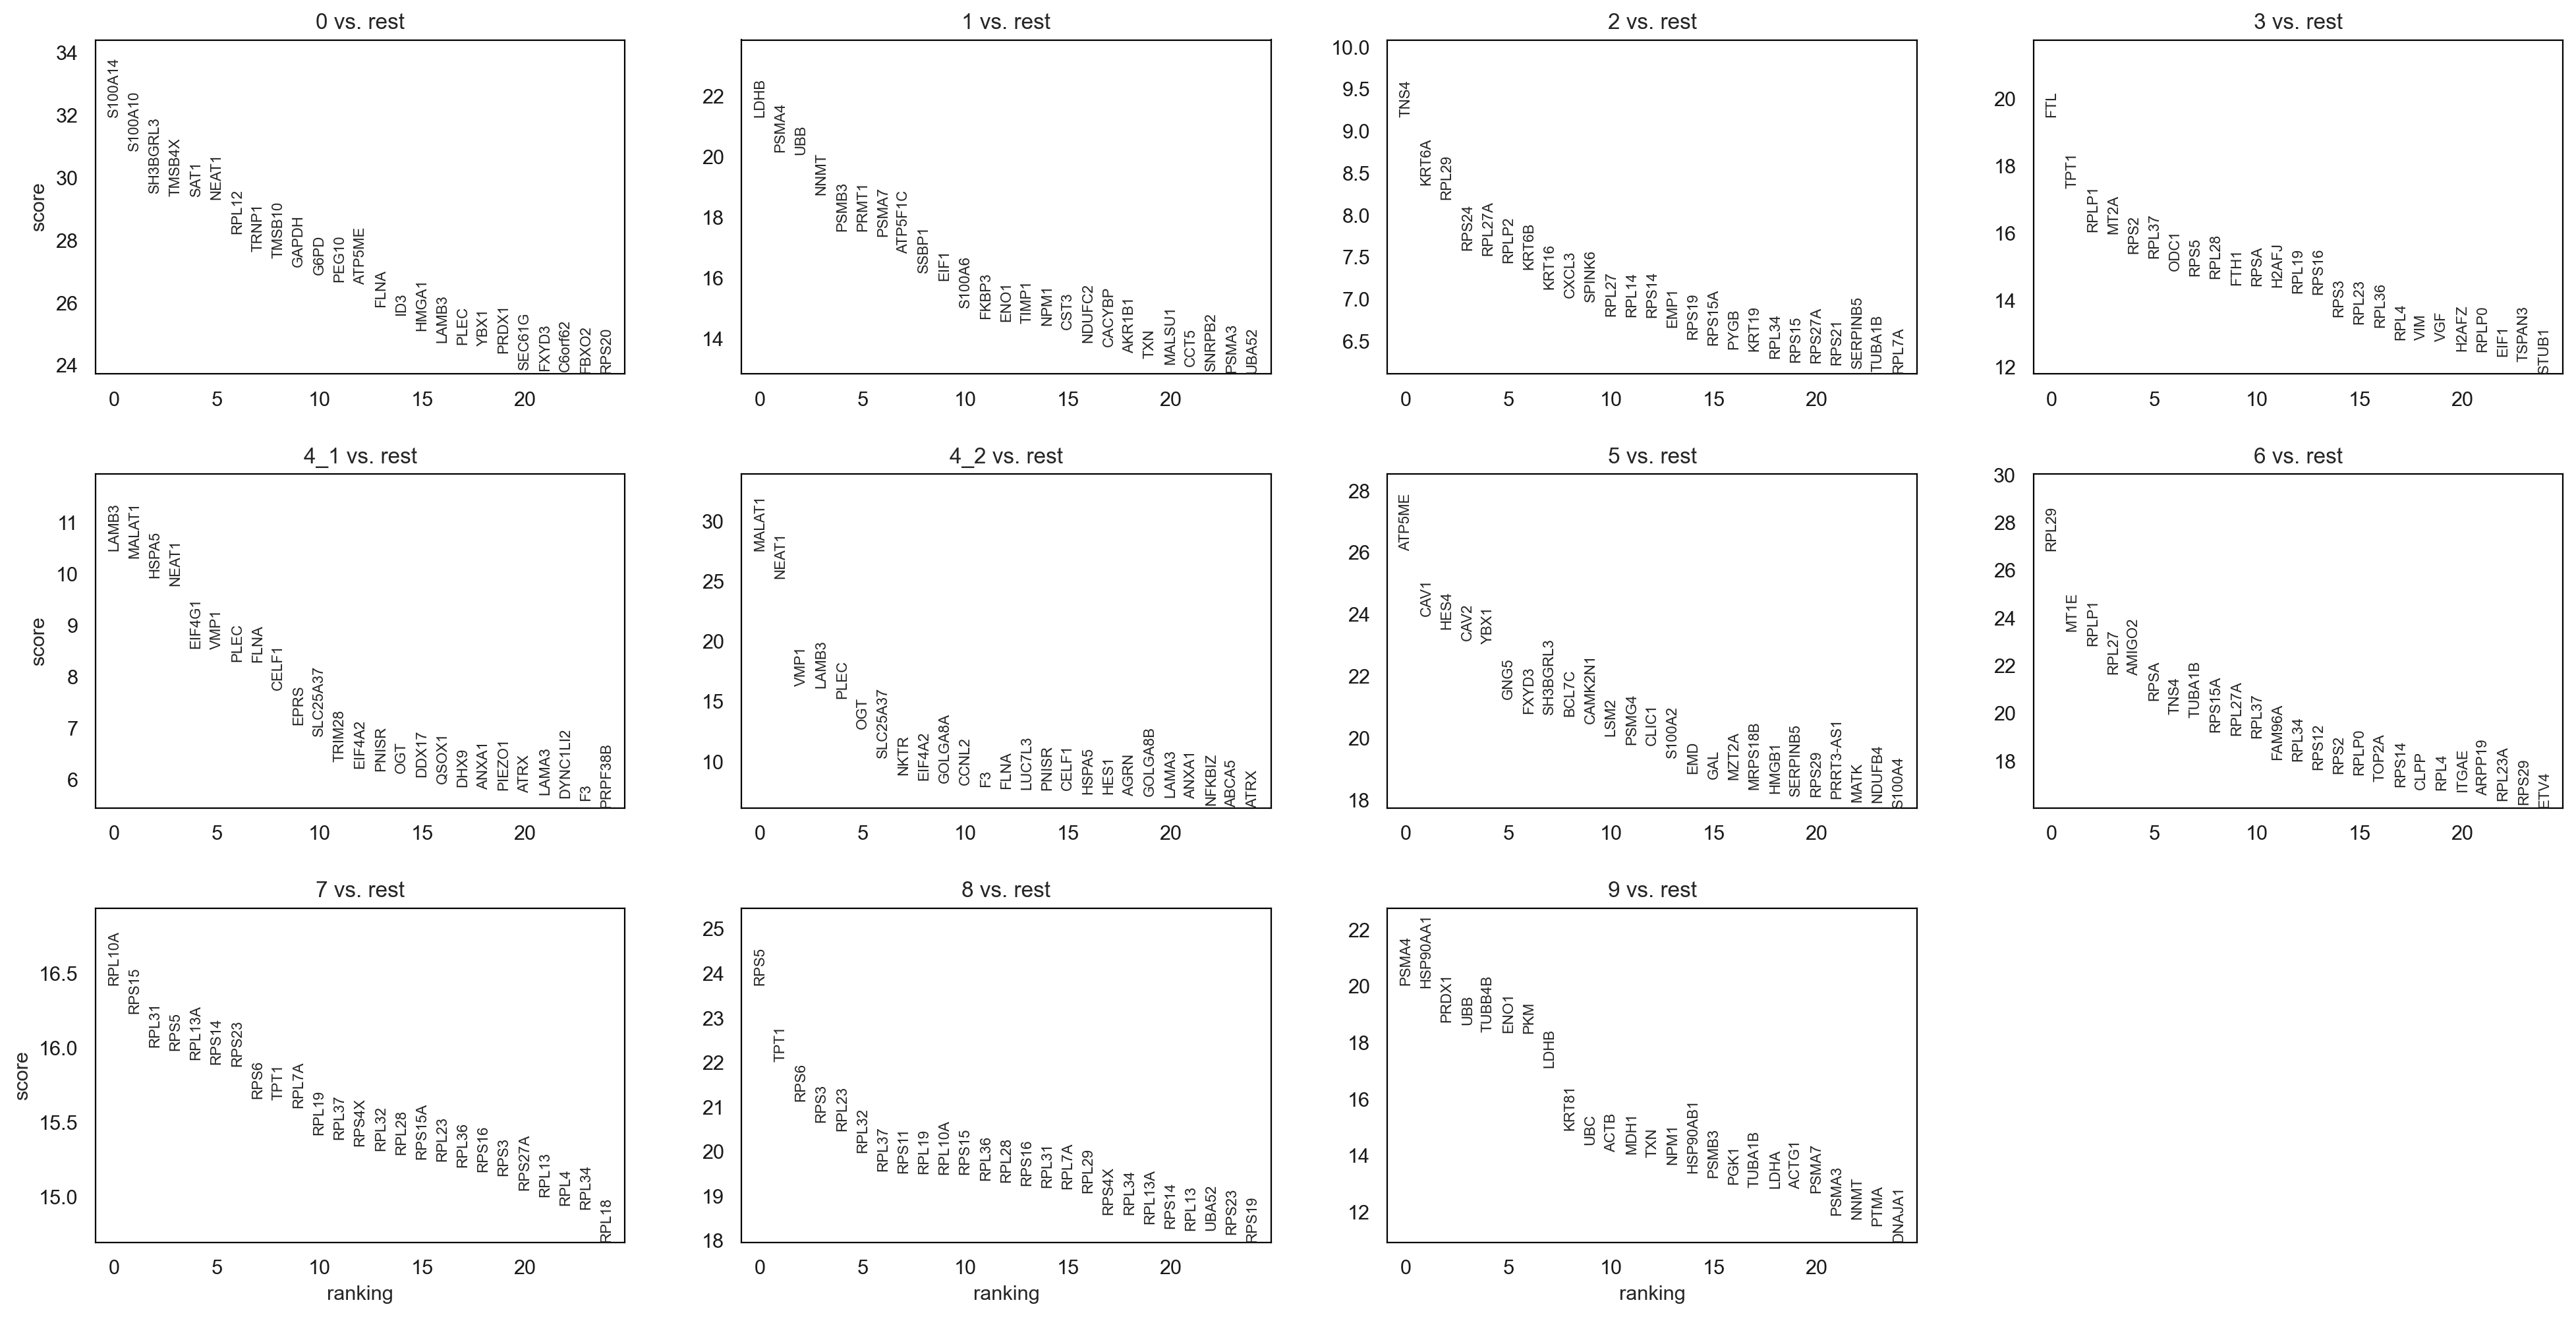

In [203]:
sc.tl.rank_genes_groups(adata, 'v_clusters', method='wilcoxon', min_log_fold_change=2, 
                        n_genes=4000,pts=True,
                        use_raw=False, layer="spliced") #when we set layer="spliced", we can extract the DEGs of each cluster according to only normalized and highly virable spliced RNA matrix. When we don't set the layer, we calculate DEGs according to scaled spliced RNA matrix. When we set use_raw="True", we will get DEGs according to raw spliced matrix even without filtering highly virable genes or outliers.
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, rankby_obs=True)

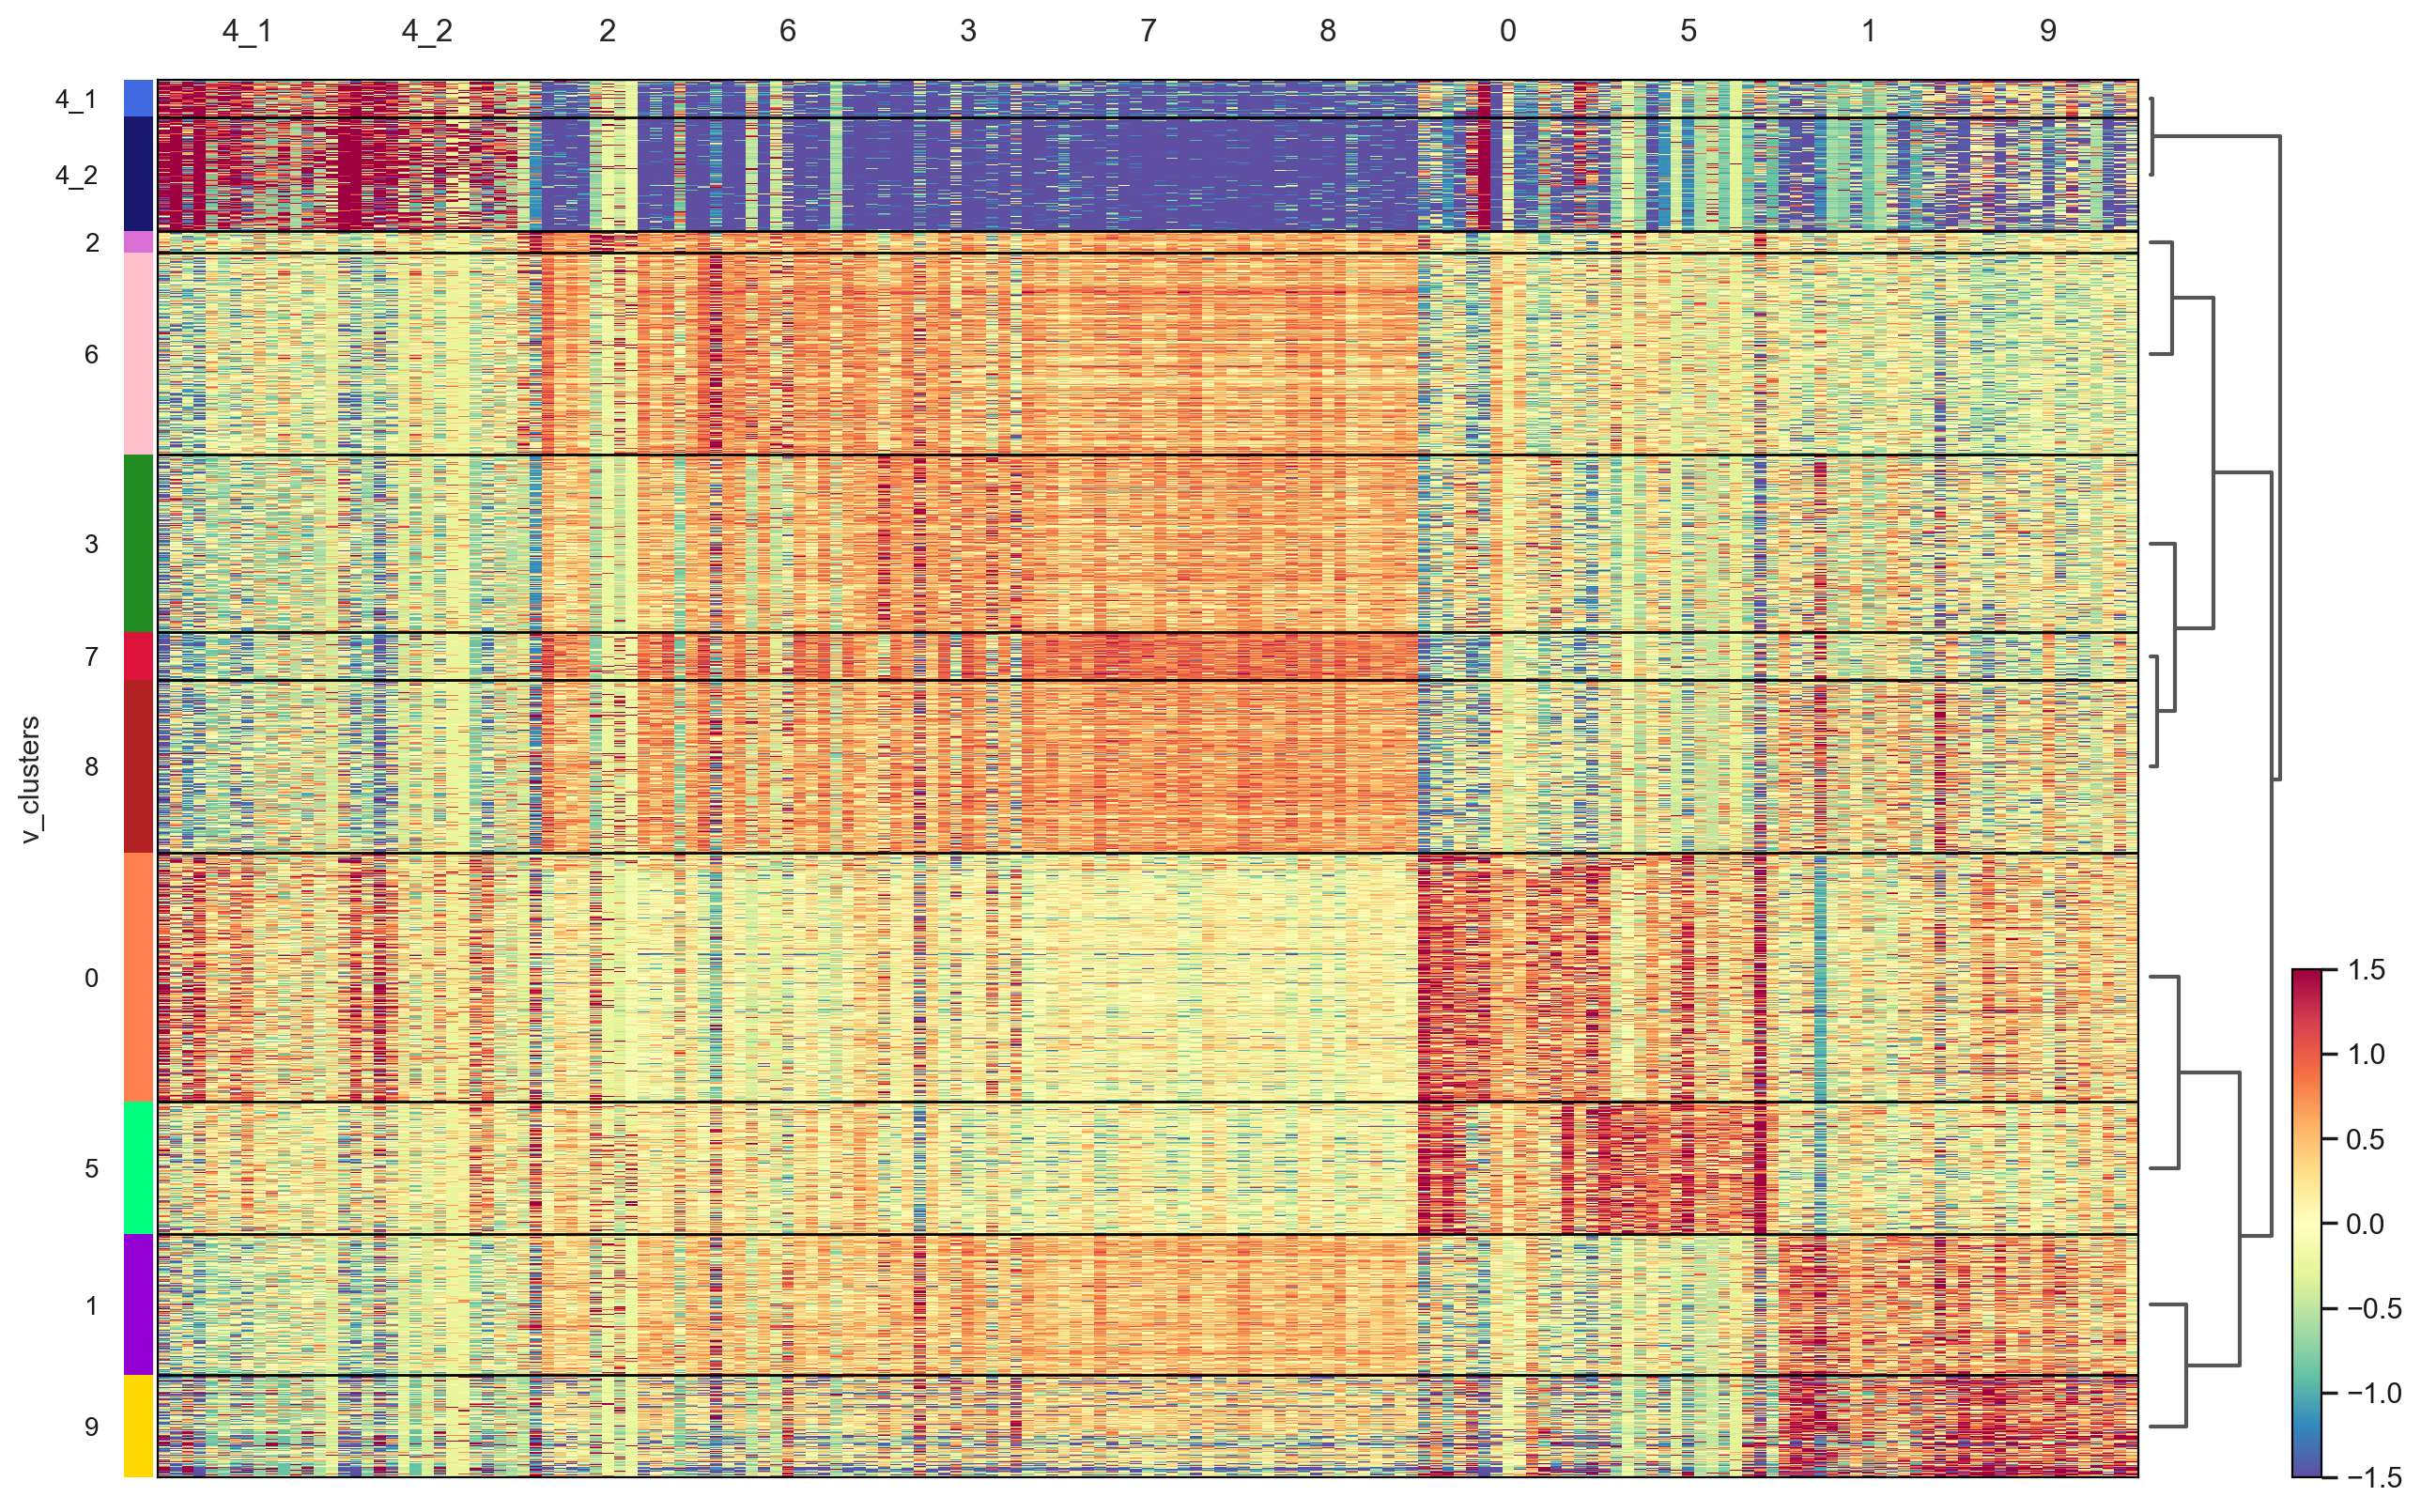

In [205]:
sc.pl.rank_genes_groups_heatmap(adata,  n_genes=15, groupby="v_clusters", 
                                #standard_scale="var",#layer="Ms",
                                vmin=-1.5, vmax=1.5,
                                cmap="Spectral_r", use_raw=False, figsize=(15,10),save="SUM149_DEG.pdf",)

In [ ]:
marker_genes={}
for i in np.unique(adata_149.obs.v_clusters):
    marker_genes[i]=result_df_149[f"{i}_n"].values[:15]

In [189]:
#save top50 DEG into dataframe, when we calculate the DEGs according to scaled matrix, because negative numbers in the matrix, we will not be able to get log fold chages, so that we can only summarize pvals_adj in to the dataframe
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
result_df=pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names' ,'pvals_adj']}).head(50)

In [82]:
# when we calculate the DEGs from raw data or normalized spliced RNA matrix, we will be able to get a dataframe containing logfoldchages. 
result= adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
result_df=pd.DataFrame(
    {group + '_' + key[:2]: result[key][group]
    for group in groups for key in ['names',"logfoldchanges", 'pvals_adj',"pts"]}).head(4000)

In [ ]:
#we can also select all the meaningful DEG by setting pval or logfoldchange cut-off manually
#for example, when we have a result_df with logfoldchages, we can get the deg list of cluster0, cluster1 and cluster2 by doing

deg=np.array([])
for i in (4,5,10):
    deg=np.append(deg,result_df.iloc[:,i*2].values)
print(deg)

In [83]:
# save the the DEG dataframe as a csv file
result_df.to_csv(f"SUM149_DEG/v_clusters_DEG4000.csv")

## ITH score

In [ ]:
#ITH score: intra tumor heterogeneity score,  ITH score is defined as the average distance between the normalized expression profiles of each cell and all other cells in the sample
#we can calculate ITH score
ITH_terms="v_clusters"
distances_t=pd.DataFrame(columns=["ITH_score"])
for i in adata.obs[f"{ITH_terms}"].unique(): 
    distances_=pd.DataFrame.sparse.from_spmatrix(adata[adata.obs[f"{ITH_terms}"]==f"{i}"].obsp["distances"],index=adata[adata.obs[f"{ITH_terms}"]==f"{i}"].obs_names)
    distances_["ITH_score"]=distances_.T.mean()
    distances_=pd.DataFrame(distances_["ITH_score"])
    distances_t=pd.concat([distances_,distances_t], axis=0)
adata.obs[f"{ITH_terms}_ITH"]=distances_t.sort_index()

## Cell fraction bar charts

In [ ]:
# we can plot feature percentage in the population we group cells, treatment or clusters
# first we need to call a cell_fraction matrix containing matched feature and group_by information of each single cell
feature="subset"
group_by="Sample_Cluster"#treatment Group
cell_fraction= pd.DataFrame(adata.obs[group_by].values,columns=[group_by],index=adata.obs[feature])

In [ ]:
fraction=pd.DataFrame([])
for i in np.unique(adata.obs[group_by]):
    adata_=adata[adata.obs[group_by]==i]
    fraction_=np.array([])
    for x in np.unique(adata.obs[feature]):
        frac=len(adata_[adata_.obs[feature]==x])
        fraction_=pd.Series(np.append(fraction_, frac))
    fraction=pd.concat([fraction, fraction_], axis=1)
fraction.columns=np.unique(adata.obs.Sample_Cluster)
fraction.index=np.unique(adata.obs[feature])

In [ ]:
# we calculate the percentage of each feature in each group
fraction.loc["sum"]=fraction.sum(axis=0)
for i in np.unique(adata.obs[feature]):
    fraction.loc[f"{i}_pct"]=fraction.loc[i]/fraction.loc["sum"]
fraction

In [ ]:
# we drop the cell number rows and leave the percentage rows
fraction_=fraction.T
for i in np.unique(adata.obs[feature]):
    fraction_=fraction_.drop([i],axis=1)
fraction_=fraction_.drop(["sum"],axis=1)
fraction_

In [ ]:
fraction_.to_csv(f"{project_ID}_figures/{feature}_fraction_v_clusters.csv")

In [ ]:
df_=fraction_
#plot the cell percentage bar chart
labels =np.unique(adata.obs[group_by])

width = 0.35      # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()
x = np.arange(0, len(labels))
bottom=0
for i in range (0, len(df_.columns)): 
    ax.bar(x,  df_.iloc[:,i], width, yerr=None, label=df_.columns[i][:1], bottom=bottom, color=scv.utils.interpret_colorkey(adata[adata.obs.subset==df_.iloc[:,i].name[:-4]],c=f"{feature}"))
    bottom=bottom+df_.iloc[:,i].values
    

plt.xticks(x, labels,rotation=90)
ax.set_ylabel('cell fraction')
ax.set_title('cell fraction')
legend=ax.legend(df_.columns,bbox_to_anchor=(1.05, 1,3,1), loc='upper left', prop={'size':10},borderpad=2)

fig.show()

In [ ]:
#plot the cell percentage bar chart
labels = np.unique(adata.obs[group_by])

width = 0.35      # the width of the bars: can also be len(x) sequence

x = np.arange(0, len(labels))
for i in range (0, len(df_.columns)): 
    fig, ax = plt.subplots()

    bottom=0
    ax.bar(x,  df_.iloc[:,i], width, yerr=None, label=df_.columns[i][:1],bottom=bottom,
           color=scv.utils.interpret_colorkey(adata[adata.obs.clusters==df_.iloc[:,i].name[:-4]],c=f"{feature}"))
    #$bottom=bottom+df_.iloc[:,i].values
    plt.xticks(x, labels)
    ax.set_ylabel('cell fraction')
    ax.set_title('cell fraction')
    legend=ax.legend(df_.columns[i],bbox_to_anchor=(1.05, 1,3,1), loc='upper left', prop={'size':10},borderpad=2)
   
    fig.show()
    fig.savefig(f"{project_ID}_figures/cell_fraction_sample_{df_.columns[i]}.pdf",bbox_extra_artists=(legend,),bbox_inches="tight",dpi=300)

## Export matrix 

In [ ]:
#export the full matrix of spliced RNA
adata.copy().T.to_df(layer="spliced").to_csv(f"./matrix_spliced.csv",header=True)

In [ ]:
#export meta data for R packages
meta_sample_clusters=pd.concat([adata.obs.clusters,adata.obs.Sample_Cluster,adata.obs.phase],axis=1)
for i in range (0,len(np.unique(adata.obs.clusters))):
    meta_sample_clusters=meta_sample_clusters.replace(f"{i}",f"cluster{i}") 
meta_sample_clusters.to_csv(f"./meta_sample_clusters_phase.csv") # I will manually remove ":" and "_" in csv index, otherwise I will have trouble of matching matrix with the metadata in R

In [ ]:
#print cluster color list in order to make R output and python output cluster colors identical
print(adata.uns["clusters_colors"])
print(adata.uns["Sample_ID_colors"])

-----------------------------------------------

## Load cytoTrace results generated from R

In [ ]:
#input cytoTRACE information to adata
cytoTRACE=pd.read_csv("CytoTRACE_s.csv",header=0, sep=",",usecols=[1],dtype=float)
adata.obs["cytoTRACE"]=cytoTRACE.values

In [ ]:
import scanpy.external as sce

In [ ]:
#smooth CD9 expression level via scanpy.external
adata_magic = sce.pp.magic(adata, name_list=["CD9"], knn=5)

In [ ]:
adata_4=adata[adata.obs.v_clusters.str.startswith("4")]
adata_9=adata[adata.obs.v_clusters=="9"]
adata_sub=adata_4.concatenate(adata_9, index_unique=None)

In [ ]:
cytotrace=adata_sub.obs.cytoTRACE

In [ ]:

densmap=adata_sub.obsm["X_densmap"]
color=scv.utils.interpret_colorkey(adata_sub,c="v_clusters")

fig=plt.figure(dpi=300)
ax=fig.add_subplot(111,projection="3d")
ax.set_title("CytoTRACE")
ax.view_init(10,220)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel('densMAP_1')
ax.set_ylabel('densMAP_2')
ax.set_zlabel('cytoTRACE')
ax.scatter(densmap[:,0], densmap[:,1], cytotrace, c=color, cmap="nipy_spectral", s=2)
plt.show
plt.savefig("SUM149_cytoTRACE.pdf")

## Save h5ad

In [103]:
adata.write(f"{project_ID}_figures/{project_ID}_pp_dy_f.h5ad")

## Pseudo-survival

In [ ]:
adata_41=adata[adata.obs.v_clusters=="4_1"]
adata_42=adata[adata.obs.v_clusters=="4_2"]
adata_9=adata[adata.obs.v_clusters=="9"]
adata_49=adata_41.concatenate([adata_9, adata_42], index_unique=None)

In [ ]:
event=pd.Series("1", adata_49.obs_names)
event[adata_49[adata_49.obs.v_clusters=="9"].obs_names]="2"

In [ ]:
pseudotime=pd.DataFrame((1-adata_49.obs.latent_time), index=adata_49.obs_names)
pseudo_event=pd.concat([event, pseudotime], axis=1)
pseudo_event.columns=["clusters", "velocity_pseudotime"]

In [ ]:
deg=result_df.loc[:,"9_n"][:30]

In [ ]:
expression=adata_49[:,deg].to_df(layer="spliced").T

In [ ]:
min_np=np.array([])
max_np=np.array([])
for k in expression.index.values:
    min_np=np.append(min_np, expression.loc[k].min())
    max_np=np.append(max_np, expression.loc[k].max())
expression["min"]=min_np
expression["max"]=max_np

In [ ]:
for i in range(0,adata_49.n_obs):
    expression[f"{expression.iloc[:,i].name}"]=(expression.iloc[:,i]-expression["min"])/(expression["max"]-expression["min"])
expression=expression.T

In [ ]:
cutoffgroup_=pd.DataFrame([], index=adata_49.obs_names)
cutoffgroup__=pd.DataFrame([], index=adata_49.obs_names)
for genes in np.unique(deg):
    cutoffgroup=pd.Series("0", adata_49.obs_names)
    cutoffgroup[expression.loc[:,f"{genes}"]>=expression.loc[:,f"{genes}"].mean()]="1"
    cutoffgroup__=pd.concat([cutoffgroup__, cutoffgroup], axis=1)

In [ ]:
cutoffgroup__.columns=np.unique(deg)

In [ ]:
pseudo_event_genes=pd.concat([pseudo_event, cutoffgroup__], axis=1)
pseudo_event_genes.to_csv(f"survival_group_latent.csv")